# How cytoplasmic is YTHDF2??

This is a crude bioinformatics analysis to peek into nuclear recruitment hypothesis.

The intuition is that, cytoplasmic RBP will bind more spliced RNA.

By looking at the CIGAR string (which writes match and mismatch/indel for each read comparing to the reference), I look for reads containing long stretches of deletion, which usually are reads spanning exon-exon junctions.

The more cytoplasmic a RBP is, more % reads will have stretches of indel.

see this post for more detail [https://www.biostars.org/p/89581/![image.png](attachment:image.png)]

I have a script calculating # read spliced and # reads mapped.

Simply `~/projects/Metadensity/scripts/percent_spliced.sh $bamfile` it will output n_spliced, n_total.

The output from that script is stored in perc_spliced.csv.


## Let's start by wrangling this file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

## see scriptes of counting bam file for f in *.bam; do ~/projects/Metadensity/scripts/percent_spliced.sh $f>>test ; done
df = pd.read_csv('perc_spliced.csv', header = None, sep = ' ', names = ['fname', 'n_spliced', 'n_total'])

# remove the merged reads
df.drop([0,1,2,3], axis = 0, inplace = True)

# compute percent reads spliced
df['perc_spliced'] = df['n_spliced']/df['n_total']

# do some labelling 
fast_id = ['m4', 'm5', 'm6', 'm10', 'm11', 'm12']
df['sample_id'] = df['fname'].str.split('.', expand = True)[1].str.split('_', expand = True)[0]
df['is_fast'] = df['sample_id'].isin(fast_id)
df['cond'] = df['is_fast'].map({True: 'fast', False: 'lib'})
df['seq_exp'] = df['fname'].str.split('.', expand = True)[1].str.split('_', expand = True)[1]
df['RBP'] = df['fname'].str.split('.', expand = True)[0].str.split('_', expand = True)[2]

In [2]:
df.head()

,fname,n_spliced,n_total,perc_spliced,sample_id,is_fast,cond,seq_exp,RBP
4,zt2_liver_YTHDF2_eCLIP.m1_IP.umi.r1.fq.genome-...,32074,739120,0.043395,m1,False,lib,IP,YTHDF2
5,zt2_liver_YTHDF2_eCLIP.m1_Input.umi.r1.fq.geno...,6626,1224750,0.005410,m1,False,lib,Input,YTHDF2
6,zt2_liver_YTHDF2_eCLIP.m2_IP.umi.r1.fq.genome-...,96972,1141520,0.084950,m2,False,lib,IP,YTHDF2
7,zt2_liver_YTHDF2_eCLIP.m2_Input.umi.r1.fq.geno...,12661,1364003,0.009282,m2,False,lib,Input,YTHDF2
8,zt2_liver_YTHDF2_eCLIP.m3_IP.umi.r1.fq.genome-...,96060,1630144,0.058927,m3,False,lib,IP,YTHDF2


# looking at the Raw percentage
There is a big difference reps. Both in Input and IP

(array([1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(1, 0, '(IP, fast, YTHDF2)'),
  Text(2, 0, '(IP, fast, m6A)'),
  Text(3, 0, '(IP, lib, YTHDF2)'),
  Text(4, 0, '(IP, lib, m6A)'),
  Text(5, 0, '(Input, fast, YTHDF2)'),
  Text(6, 0, '(Input, fast, m6A)'),
  Text(7, 0, '(Input, lib, YTHDF2)'),
  Text(8, 0, '(Input, lib, m6A)')])

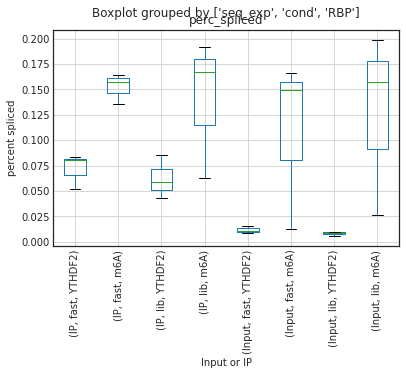

In [3]:

df.boxplot(by = ['seq_exp', 'cond', 'RBP'], column = ['perc_spliced'])
plt.ylabel('percent spliced')
plt.xlabel('Input or IP')
plt.xticks(rotation = 90)

# Therefore we should calculate enrichment over Input

enrichment = `percent spliced in IP` divided by `percent spliced in Input`

In [4]:
# caluclate enrichment
result = []
for name, group in df.groupby('sample_id'):
    group = group.set_index('seq_exp')
    ip = group.loc['IP', 'perc_spliced']
    input_ = group.loc['Input', 'perc_spliced']
    enrichment = ip/input_
    cond = group.loc['IP', 'cond']
    rbp =  group.loc['IP', 'RBP']
    result.append([name, enrichment, ip, input_, cond, rbp])

sample_enrichment = pd.DataFrame(result, columns = ['sample_id', 'enrichment', 'perc_IP', 'perc_Input', 'is_fast', 'RBP'])

In [5]:
sample_enrichment

,sample_id,enrichment,perc_IP,perc_Input,is_fast,RBP
0,m1,8.021105,0.043395,0.005410,lib,YTHDF2
1,m10,0.949356,0.157611,0.166019,fast,m6A
2,m11,10.843855,0.135514,0.012497,fast,m6A
3,m12,1.099401,0.164097,0.149261,fast,m6A
4,m2,9.151876,0.084950,0.009282,lib,YTHDF2
5,m3,6.623427,0.058927,0.008897,lib,YTHDF2
6,m4,4.823221,0.052224,0.010828,fast,YTHDF2
7,m5,9.455330,0.080126,0.008474,fast,YTHDF2
8,m6,5.358448,0.083279,0.015542,fast,YTHDF2
9,m7,0.964105,0.191651,0.198786,lib,m6A


# fasted YTHDF2 has less enrichment (less cytoplasmic)

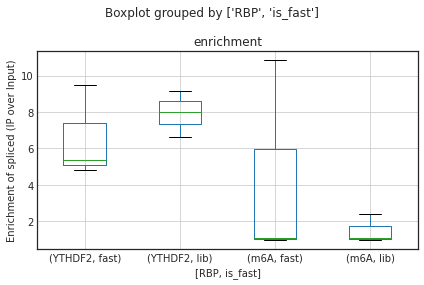

In [6]:
sample_enrichment.boxplot(column = ['enrichment'], by = ['RBP', 'is_fast'])
plt.ylabel('Enrichment of spliced (IP over Input)')
plt.tight_layout()

# Although they have higher % spliced IP
They also have higher % spliced in Input

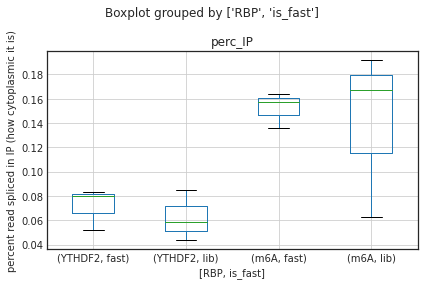

In [7]:
sample_enrichment.boxplot(column = ['perc_IP'], by = ['RBP', 'is_fast'])
plt.ylabel('percent read spliced in IP (how cytoplasmic it is)')
plt.tight_layout()

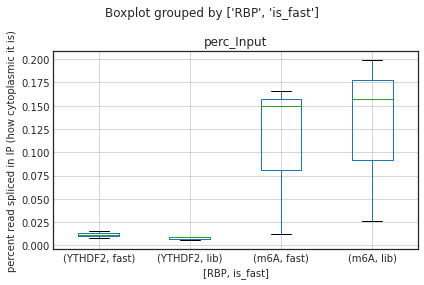

In [8]:
sample_enrichment.boxplot(column = ['perc_Input'], by = ['RBP', 'is_fast'])
plt.ylabel('percent read spliced in IP (how cytoplasmic it is)')
plt.tight_layout()